In [1]:
from google.colab import drive
ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
!ls '/content/gdrive/My Drive/Colab_Notebooks/my_project1/deep_learning/S15_A/images/dense_depth'

dense_depth  fg_bg  fg_bg_mask	fg_mask  foreground


In [10]:
# from tqdm.notebook import tqdm
# def extract_image(zip_list, folder_copy):
#   for zip_file in tqdm(zip_list):
#     folder_name = '/content/ImageData/Extracted/fg_bg_mask'
#     with zipfile.ZipFile(zip_file, 'r') as zip:
#       zip.extractall(folder_name)
# def extract_dense(zip_list, folder_copy):
#   for zip_file in tqdm(zip_list):
#     print("from : ",zip_file)
#     folder_identifier = zip_file.split("/")[-1].split(".")[0].split("depth_mask_")[-1]
#     extract_to = os.path.join(folder_name, folder_identifier)
#     with zipfile.ZipFile(zip_file, 'r') as zip:
#       print("to : ",extract_to)
#       zip.extractall(extract_to)

In [19]:
# %%time
# import glob
# from zipfile import ZipFile
# import zipfile
# # from tqdm.notebook import tqdm
# #!mkdir /content/ImageData_Zip
# # !mkdir /content/Extract

# #copy zip files
# # !cp -r '/content/gdrive/My Drive/Colab_Notebooks/my_project1/deep_learning/S15_A/images/fg_bg' -d '/content/ImageData_Zip'
# # !cp -r '/content/gdrive/My Drive/Colab_Notebooks/my_project1/deep_learning/S15_A/images/fg_bg_mask' -d '/content/ImageData_Zip'
# !cp -r '/content/gdrive/My Drive/Colab_Notebooks/my_project1/deep_learning/S15_A/images/dense_depth' -d '/content/ImageData_Zip'

# #copy image folders
# #!cp -r '/content/gdrive/My Drive/Colab_Notebooks/my_project1/deep_learning/S15_A/extracted_images/background' -d '/content/Extract'
# #zip_list1 = sorted([f for f in glob.glob('/content/ImageData_Zip/fg_bg_mask/*.zip')])
# zip_list2 = sorted([f for f in glob.glob('/content/ImageData_Zip/fg_bg_dense_depth/*.zip')])
# #zip_list3 = sorted([f for f in glob.glob('/content/ImageData_Zip/fg_bg/*.zip')])
# path = '/content/Extract/'
# #extract_image(zip_list1, path)
# extract_dense(zip_list2, path)
#extract_image(zip_list3, path)


CPU times: user 122 ms, sys: 11.5 ms, total: 134 ms
Wall time: 58.7 s


In [2]:
import os
basePath = '/content/gdrive/My Drive/Colab_Notebooks/my_project1/deep_learning/S15_A/'
os.chdir(basePath)

In [3]:
import os
from utils.customset import CustomDataset, SubDatasetTransform
from utils.helper import *
from utils.viz import image_show, show_grid_images
from utils.unet_custom_model import Unet

In [5]:
%%time
# print(sum([len(files) for r,d, files in os.walk('extracted_images/fg_bg')]))
# print(sum([len(files) for r,d, files in os.walk('extracted_images/fg_bg_mask')]))
# print(sum([len(files) for r,d, files in os.walk('extracted_images/fg_bg_dense_depth')]))

400000
400000
400000
CPU times: user 1.27 s, sys: 235 ms, total: 1.51 s
Wall time: 9.29 s


In [20]:
dataset = CustomDataset("/content/gdrive/My Drive/Colab_Notebooks/my_project1/deep_learning/S15_A/extracted_images", start=1, end=3)

*****************start*****************
*****************end*****************


In [21]:
trainlen = int(len(dataset)*0.7)
testlen = len(dataset) - trainlen
train_set, val_set = torch.utils.data.random_split(dataset, [trainlen, testlen])

In [22]:
print(len(train_set))
print(len(val_set))

8400
3600


In [23]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
if device == "cuda":
  print(device)
  SEED = 1
  torch.cuda.manual_seed(SEED)

In [39]:
from torch.utils.data import DataLoader
train = SubDatasetTransform(train_set, resize_image=128)
test = SubDatasetTransform(val_set, resize_image=128)

dataloader_args = dict(shuffle=True, batch_size=8, num_workers=4,
                               pin_memory=True) if cuda else dict(shuffle=True, batch_size=8)

train_dataloader = DataLoader(train, **dataloader_args)
test_dataloader = DataLoader(test, **dataloader_args)

In [40]:
# def pickle_data(data_list, name):
#     """
#     :param data: list of item eg: test_image.pkl
#     :param name: file name to pickle
#     :return: None
#     """
#     with open(name, 'wb') as f:
#         pickle.dump(data_list, f)

pickle_data( [train_dataloader, test_dataloader], 'pickle_data/dataset_b_8_s_128_40k_1_3.pkl')

In [41]:
# with open('dataset_b_8_s_64_12k.pkl', 'rb') as f:
#   stored_data = pickle.load(f)

stored_data = read_pickle('pickle_data/dataset_b_8_s_128_40k_1_3.pkl')
train_dataloader_pick = stored_data[0]
test_dataloader_pick = stored_data[1]

In [42]:
sample1 = iter(train_dataloader_pick)
sample = next(sample1)
bg = sample["input_images"][: :3, :, :]
fg_bg= sample["input_images"][: 3:, :, :]
print({"bg": bg.size()})
print({"fg_bg":fg_bg.size()})
print({"bg": sample["bg"].size()})
print({"fg":sample["fg_bg"].size()})
print({"mask": sample["mask"].size()})
print({"dense":sample["dense"].size()})
print(sample["input_images"].size())

{'bg': torch.Size([3, 6, 128, 128])}
{'fg_bg': torch.Size([3, 6, 128, 128])}
{'bg': torch.Size([8, 3, 128, 128])}
{'fg': torch.Size([8, 3, 128, 128])}
{'mask': torch.Size([8, 1, 128, 128])}
{'dense': torch.Size([8, 1, 128, 128])}
torch.Size([8, 6, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


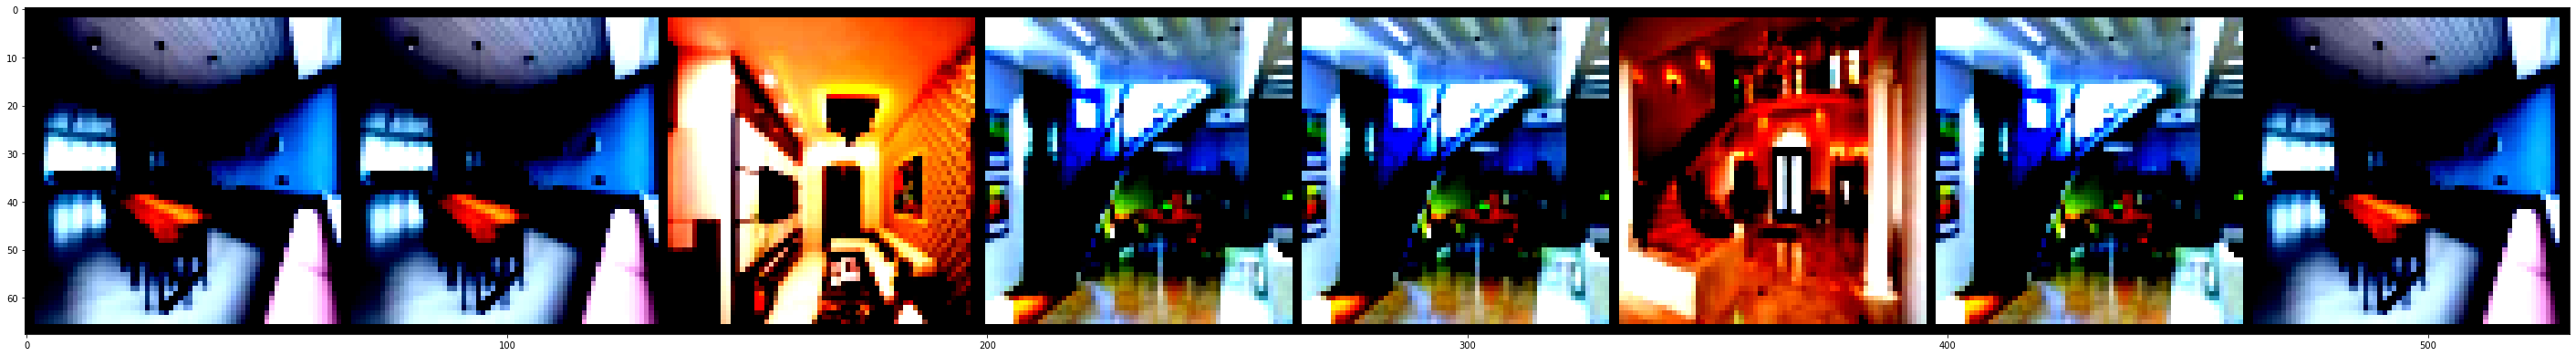

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


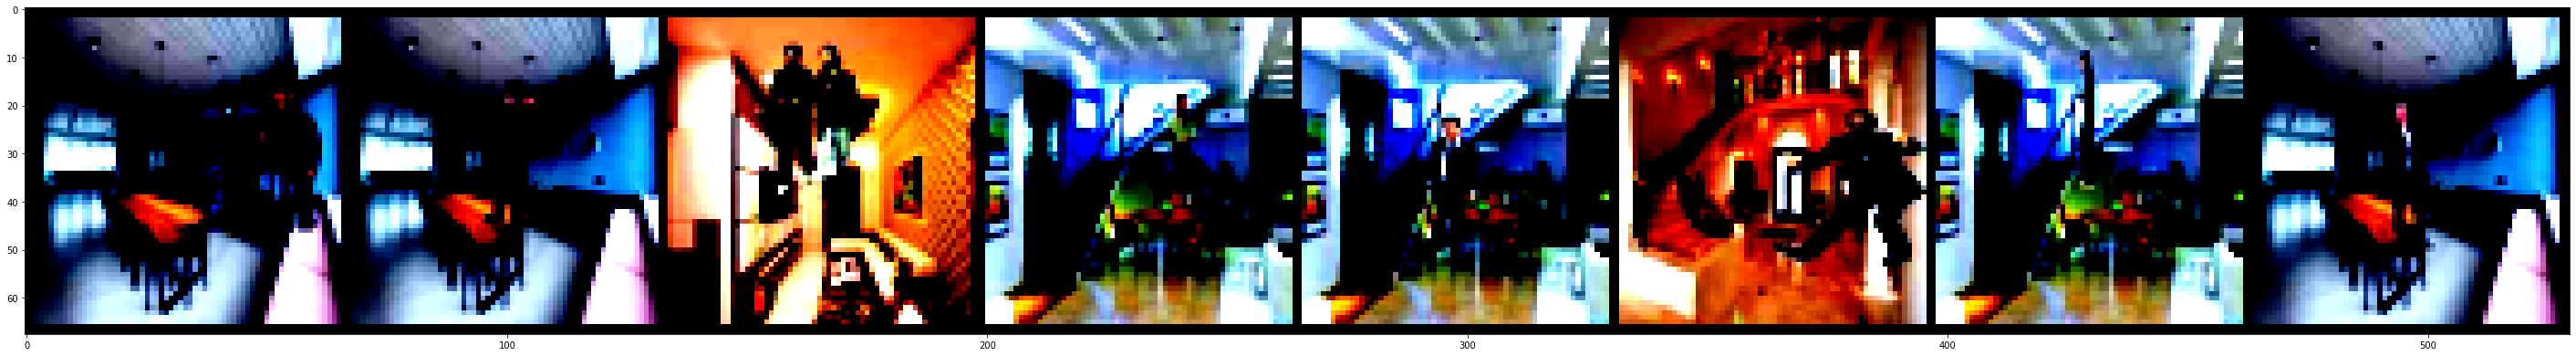

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


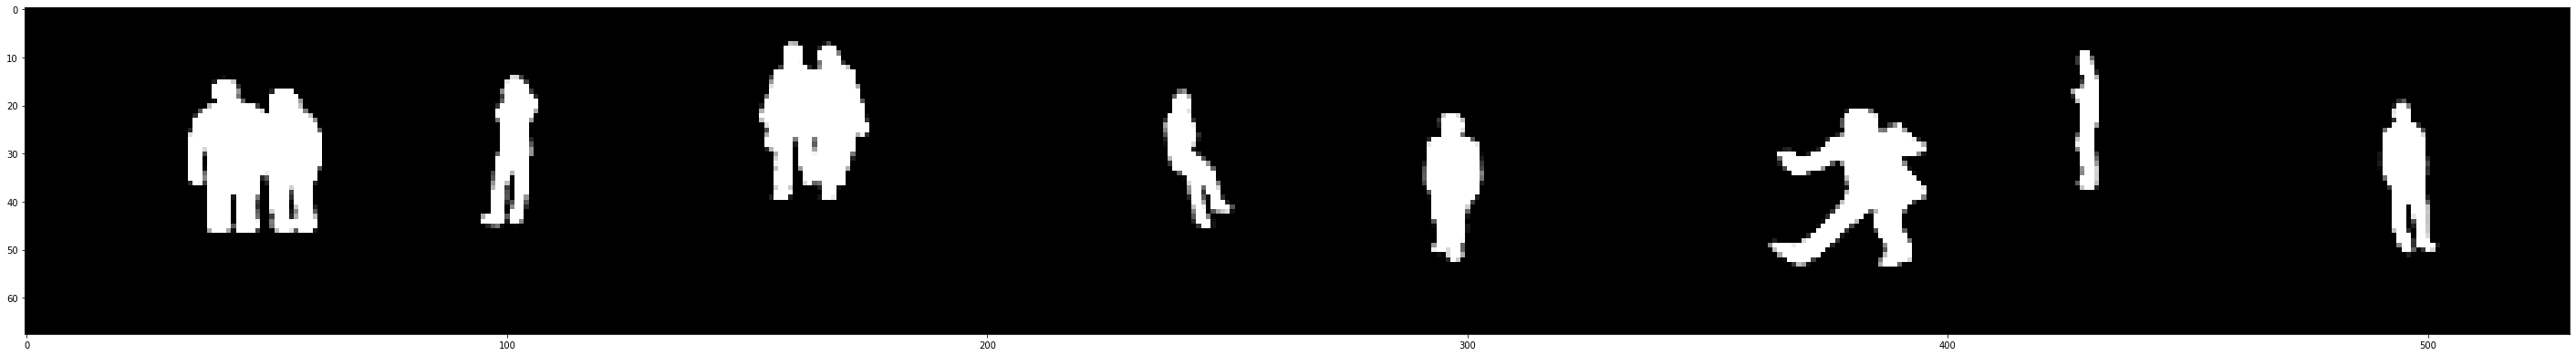

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


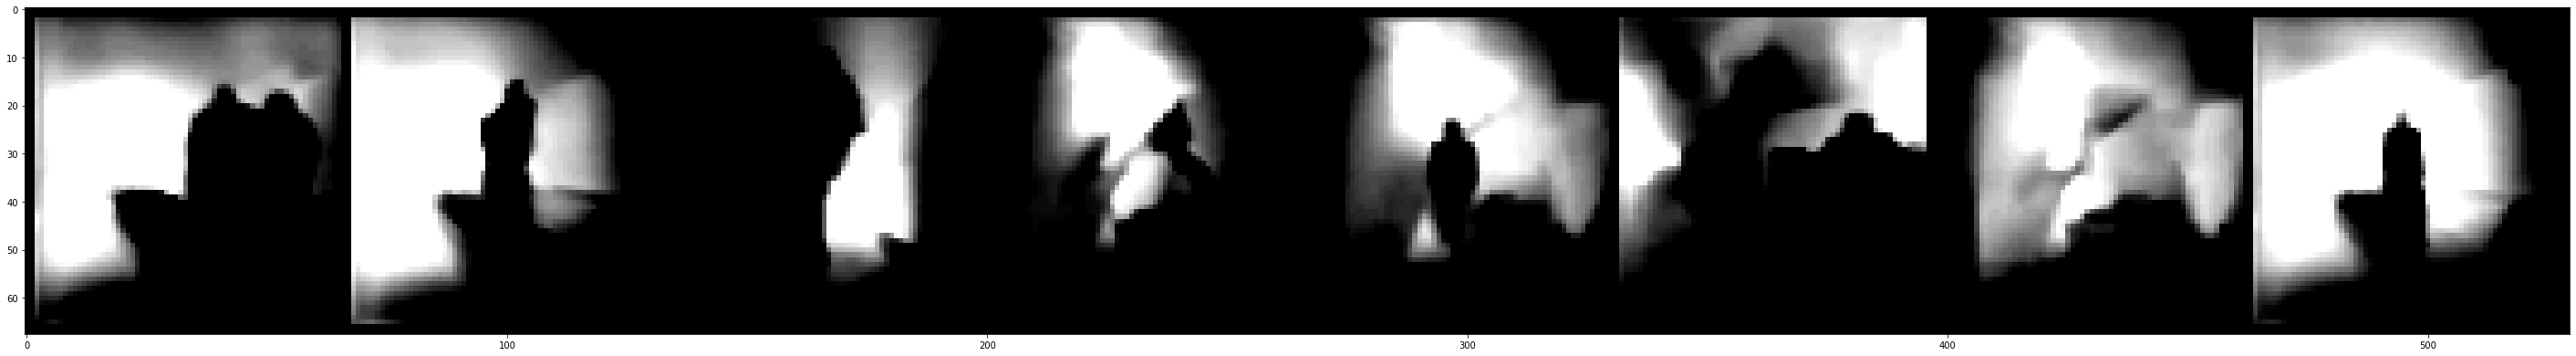

In [80]:
image_show(sample["bg"].resize_(8, 3, 64, 64))
image_show(sample["fg_bg"].resize_(8, 3, 64, 64))
image_show(sample["mask"].resize_(8, 1, 64, 64))
image_show(sample["dense"].resize_(8, 1, 64, 64))

In [18]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
model = Unet(num_channels=6, num_classes=1, bilinear=True).to(device)
summary(model, input_size=(6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,760
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
             Down-14           [-1, 64,

**Train model for image size 64**

In [29]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

from utils.train import Train
from utils.test import Test


EPOCHS = 16

train_obj = Train()
test_obj = Test()
model = Unet(num_channels=6, num_classes=1, bilinear=True).to(device)

optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler = None

criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, EPOCHS):
    train_obj.train(model, device, train_dataloader_pick, optimizer, criterion, epoch)
    test_obj.test(model, device, test_dataloader_pick, criterion, epoch)
    if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
      scheduler.step(metrics=test_obj.test_losses[-1])


Train Set: Epoch : 1 | avg mask loss =0.5223453498454321 | avg dense depth losss =0.5913529108535676 | avg total loss = 1.96317720413208 | avg iou mask=0.8308793390499138 |avg iou dense depth=0.601506187475255


Test Set: Epoch : 1 | batch idx = 449 | mask loss =0.5305091142654419 | dense depth losss =0.5010437965393066 | total loss = 1.0315529108047485 | iou mask=0.8652759675563843 |iou dense depth=0.7797959332948868: 100%|██████████| 450/450 [19:30<00:00,  2.60s/it]

Test Set: Epoch : 1 | avg mask loss =0.5140956908464431 | avg dense depth losss =0.5729446459478802 | avg total loss = 1.0870400667190552 | avg iou mask=0.8774676803821463 |avg iou dense depth=0.6915138111917633



Train Set: Epoch : 2 | avg mask loss =0.5119749145280748 | avg dense depth losss =0.5729335511582239 | avg total loss = 1.96317720413208 | avg iou mask=0.9042353172250468 |avg iou dense depth=0.6847392445462493


Test Set: Epoch : 2 | batch idx = 449 | mask loss =0.5455060601234436 | dense depth losss =0.5715230703353882 | total loss = 1.1170291900634766 | iou mask=0.8948443088573542 |iou dense depth=0.6594334937390811: 100%|██████████| 450/450 [00:44<00:00, 10.05it/s]

Test Set: Epoch : 2 | avg mask loss =0.5135115203592512 | avg dense depth losss =0.5835410937335757 | avg total loss = 1.0870400667190552 | avg iou mask=0.8983182509981348 |avg iou dense depth=0.6695490360192765


*******saving model*********
*******saving model*********
*******saving model*********
*******saving model*********

Train Set: Epoch : 3 | avg mask loss =0.5117453826609112 | avg dense depth losss =0.5702138017188935 | avg total loss = 1.96317720413208 | avg iou mask=0.9095379174321918 |avg iou dense depth=0.6989140627836472


Test Set: Epoch : 3 | batch idx = 449 | mask loss =0.5078054666519165 | dense depth losss =0.5712265968322754 | total loss = 1.079032063484192 | iou mask=0.8977505116656421 |iou dense depth=0.7566800433036311: 100%|██████████| 450/450 [00:45<00:00,  9.85it/s]

*******saving test batch images*********
Test Set: Batch idx = 449 |epoch : 3, mask loss =0.5078054666519165 | dense depth losss =0.5712265968322754 | total loss = 1.079032063484192 | iou Mask=0.8977505116656421 |iou Dense depth=0.7566800433036311
Test Set: Epoch : 3 | avg mask loss =0.5140750730699963 | avg dense depth losss =0.5715701189306047 | avg total loss = 1.0870400667190552 | avg iou mask=0.8856432743765422 |avg iou dense depth=0.6809873278808951



Train Set: Epoch : 4 | avg mask loss =0.5109082662775403 | avg dense depth losss =0.5688708959023158 | avg total loss = 1.96317720413208 | avg iou mask=0.9213060115348568 |avg iou dense depth=0.7052742058538284


Test Set: Epoch : 4 | batch idx = 449 | mask loss =0.44276219606399536 | dense depth losss =0.5645461082458496 | total loss = 1.0073082447052002 | iou mask=0.9378475631735441 |iou dense depth=0.6779487182028018: 100%|██████████| 450/450 [00:45<00:00,  9.97it/s]

Test Set: Epoch : 4 | avg mask loss =0.5116714539130529 | avg dense depth losss =0.5699609484937456 | avg total loss = 1.0870400667190552 | avg iou mask=0.9180281250312752 |avg iou dense depth=0.7300802828702655



Train Set: Epoch : 5 | avg mask loss =0.5106812168586822 | avg dense depth losss =0.5679065085592724 | avg total loss = 1.96317720413208 | avg iou mask=0.9249450069771821 |avg iou dense depth=0.7105618573691204


Test Set: Epoch : 5 | batch idx = 449 | mask loss =0.5043094158172607 | dense depth losss =0.5825642943382263 | total loss = 1.0868737697601318 | iou mask=0.934719334990772 |iou dense depth=0.7213917188498588: 100%|██████████| 450/450 [00:43<00:00, 10.44it/s]

Test Set: Epoch : 5 | avg mask loss =0.5114711676041285 | avg dense depth losss =0.5680834017859565 | avg total loss = 1.0870400667190552 | avg iou mask=0.9240886919669754 |avg iou dense depth=0.7290061415886443


*******saving model*********

Train Set: Epoch : 6 | avg mask loss =0.5104843078056971 | avg dense depth losss =0.5666832943473543 | avg total loss = 1.96317720413208 | avg iou mask=0.9281242002617546 |avg iou dense depth=0.7175975257561558


Test Set: Epoch : 6 | batch idx = 449 | mask loss =0.5205312371253967 | dense depth losss =0.5145595073699951 | total loss = 1.035090684890747 | iou mask=0.9325643303790403 |iou dense depth=0.6601185163892211: 100%|██████████| 450/450 [00:42<00:00, 10.65it/s]

*******saving test batch images*********
Test Set: Batch idx = 449 |epoch : 6, mask loss =0.5205312371253967 | dense depth losss =0.5145595073699951 | total loss = 1.035090684890747 | iou Mask=0.9325643303790403 |iou Dense depth=0.6601185163892211
Test Set: Epoch : 6 | avg mask loss =0.5112341142363018 | avg dense depth losss =0.568418729768859 | avg total loss = 1.0870400667190552 | avg iou mask=0.9283179701964415 |avg iou dense depth=0.710065756869791



Train Set: Epoch : 7 | avg mask loss =0.5106011717660086 | avg dense depth losss =0.5661556351184845 | avg total loss = 1.96317720413208 | avg iou mask=0.9269605434372079 |avg iou dense depth=0.7214652104743347


Test Set: Epoch : 7 | batch idx = 449 | mask loss =0.461500883102417 | dense depth losss =0.6431496143341064 | total loss = 1.1046504974365234 | iou mask=0.9436158605179489 |iou dense depth=0.5726980997621598: 100%|██████████| 450/450 [00:49<00:00,  9.02it/s]


Test Set: Epoch : 7 | avg mask loss =0.5116572443644206 | avg dense depth losss =0.5669150827328364 | avg total loss = 1.0870400667190552 | avg iou mask=0.9207289063009463 |avg iou dense depth=0.7133915438231362



Train Set: Epoch : 8 | avg mask loss =0.5103491974160784 | avg dense depth losss =0.5653405394156774 | avg total loss = 1.96317720413208 | avg iou mask=0.9303642221758055 |avg iou dense depth=0.7260458061445833


Test Set: Epoch : 8 | batch idx = 449 | mask loss =0.5515056252479553 | dense depth losss =0.5479822158813477 | total loss = 1.0994877815246582 | iou mask=0.9195640896753291 |iou dense depth=0.7541934805842457: 100%|██████████| 450/450 [00:46<00:00,  9.59it/s]

Test Set: Epoch : 8 | avg mask loss =0.5111688431766298 | avg dense depth losss =0.5676126251618068 | avg total loss = 1.0870400667190552 | avg iou mask=0.9289730964266969 |avg iou dense depth=0.7228906397329844


*******saving model*********

Train Set: Epoch : 9 | avg mask loss =0.510180394904954 | avg dense depth losss =0.5645014947652817 | avg total loss = 1.96317720413208 | avg iou mask=0.9335478370367066 |avg iou dense depth=0.729298931686424


Test Set: Epoch : 9 | batch idx = 449 | mask loss =0.5316977500915527 | dense depth losss =0.5924012660980225 | total loss = 1.1240990161895752 | iou mask=0.921743205615074 |iou dense depth=0.7679588720745326: 100%|██████████| 450/450 [00:47<00:00,  9.47it/s]

*******saving test batch images*********
Test Set: Batch idx = 449 |epoch : 9, mask loss =0.5316977500915527 | dense depth losss =0.5924012660980225 | total loss = 1.1240990161895752 | iou Mask=0.921743205615074 |iou Dense depth=0.7679588720745326
Test Set: Epoch : 9 | avg mask loss =0.511094589498308 | avg dense depth losss =0.5649536269903183 | avg total loss = 1.0870400667190552 | avg iou mask=0.9308358108685097 |avg iou dense depth=0.7310562764621665



Train Set: Epoch : 10 | avg mask loss =0.510117598431451 | avg dense depth losss =0.5639286684422266 | avg total loss = 1.96317720413208 | avg iou mask=0.9344496631078042 |avg iou dense depth=0.7326704910388013


Test Set: Epoch : 10 | batch idx = 449 | mask loss =0.5325551629066467 | dense depth losss =0.5881229043006897 | total loss = 1.1206780672073364 | iou mask=0.9258361612901784 |iou dense depth=0.7174595208767923: 100%|██████████| 450/450 [00:49<00:00,  9.15it/s]

Test Set: Epoch : 10 | avg mask loss =0.5112240233023961 | avg dense depth losss =0.5651769747998979 | avg total loss = 1.0870400667190552 | avg iou mask=0.9290119691919471 |avg iou dense depth=0.7426889211813835



Train Set: Epoch : 11 | avg mask loss =0.5100603255487623 | avg dense depth losss =0.5632253644579933 | avg total loss = 1.96317720413208 | avg iou mask=0.9359467453467621 |avg iou dense depth=0.736393762399823


Test Set: Epoch : 11 | batch idx = 449 | mask loss =0.5551352500915527 | dense depth losss =0.6019574403762817 | total loss = 1.1570926904678345 | iou mask=0.9177282382286187 |iou dense depth=0.6617693032595923: 100%|██████████| 450/450 [00:46<00:00,  9.61it/s]

Test Set: Epoch : 11 | avg mask loss =0.5112344315979216 | avg dense depth losss =0.5676525453726451 | avg total loss = 1.0870400667190552 | avg iou mask=0.9289098295161148 |avg iou dense depth=0.7066786930528626


*******saving model*********

Train Set: Epoch : 12 | avg mask loss =0.5100022726967222 | avg dense depth losss =0.5625234230075564 | avg total loss = 1.96317720413208 | avg iou mask=0.9368858875833916 |avg iou dense depth=0.7400523974476552


Test Set: Epoch : 12 | batch idx = 449 | mask loss =0.5337563157081604 | dense depth losss =0.5313923358917236 | total loss = 1.0651485919952393 | iou mask=0.9287762909714325 |iou dense depth=0.7133191574392816: 100%|██████████| 450/450 [00:49<00:00,  9.18it/s]

Test Set: Epoch : 12 | avg mask loss =0.5112236966027154 | avg dense depth losss =0.5636903746260538 | avg total loss = 1.0870400667190552 | avg iou mask=0.9277412412643199 |avg iou dense depth=0.723453328232053



Train Set: Epoch : 13 | avg mask loss =0.5099624510038466 | avg dense depth losss =0.5622412646100634 | avg total loss = 1.96317720413208 | avg iou mask=0.9372856307401316 |avg iou dense depth=0.7421715169119224


Test Set: Epoch : 13 | batch idx = 449 | mask loss =0.4974510371685028 | dense depth losss =0.4998891055583954 | total loss = 0.9973401427268982 | iou mask=0.9394572027580075 |iou dense depth=0.7014145421196373: 100%|██████████| 450/450 [00:43<00:00, 10.39it/s]

Test Set: Epoch : 13 | avg mask loss =0.5107183445824517 | avg dense depth losss =0.565737431579166 | avg total loss = 1.0870400667190552 | avg iou mask=0.9374995020436943 |avg iou dense depth=0.70135817433731



Train Set: Epoch : 14 | avg mask loss =0.5098189416953496 | avg dense depth losss =0.5613709575221653 | avg total loss = 1.96317720413208 | avg iou mask=0.9397353908379452 |avg iou dense depth=0.7471165881704824


Test Set: Epoch : 14 | batch idx = 449 | mask loss =0.47645333409309387 | dense depth losss =0.5988996028900146 | total loss = 1.0753529071807861 | iou mask=0.9328018225785808 |iou dense depth=0.7220402437653405: 100%|██████████| 450/450 [00:43<00:00, 10.23it/s]

Test Set: Epoch : 14 | avg mask loss =0.5105834671523836 | avg dense depth losss =0.5635155679119958 | avg total loss = 1.0870400667190552 | avg iou mask=0.9408249957338385 |avg iou dense depth=0.7472156187001


*******saving model*********

Train Set: Epoch : 15 | avg mask loss =0.5097836930411203 | avg dense depth losss =0.560599931762332 | avg total loss = 1.96317720413208 | avg iou mask=0.9407491834717128 |avg iou dense depth=0.7515634603715081


Test Set: Epoch : 15 | batch idx = 449 | mask loss =0.5066972970962524 | dense depth losss =0.5809472799301147 | total loss = 1.0876445770263672 | iou mask=0.9461439037219134 |iou dense depth=0.7516639892682304: 100%|██████████| 450/450 [00:47<00:00,  9.38it/s]

*******saving test batch images*********
Test Set: Batch idx = 449 |epoch : 15, mask loss =0.5066972970962524 | dense depth losss =0.5809472799301147 | total loss = 1.0876445770263672 | iou Mask=0.9461439037219134 |iou Dense depth=0.7516639892682304
Test Set: Epoch : 15 | avg mask loss =0.5105559068918228 | avg dense depth losss =0.5634416870938407 | avg total loss = 1.0870400667190552 | avg iou mask=0.9420946083592785 |avg iou dense depth=0.7454340675588474


In [50]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

from utils.train import Train
from utils.test import Test


EPOCHS = 10

train_obj = Train()
test_obj = Test()
model = Unet(num_channels=6, num_classes=1, bilinear=True).to(device)

optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler = None

criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, EPOCHS):
    train_obj.train(model, device, train_dataloader_pick, optimizer, criterion, epoch)
    test_obj.test(model, device, test_dataloader_pick, criterion, epoch)
    if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
      scheduler.step(metrics=test_obj.test_losses[-1])


Train Set: Epoch : 1 | avg mask loss =0.5133707857699621 | avg dense depth losss =0.5912187320561636 | avg total loss = 2.11963152885437 | avg iou mask=0.8621829025787683 |avg iou dense depth=0.6202457362454247


Test Set: Epoch : 1 | batch idx = 449 | mask loss =0.48115330934524536 | dense depth losss =0.6085103750228882 | total loss = 1.0896637439727783 | iou mask=0.9280804350794292 |iou dense depth=0.6528142694546074: 100%|██████████| 450/450 [01:13<00:00,  6.15it/s]

Test Set: Epoch : 1 | avg mask loss =0.5062879546483358 | avg dense depth losss =0.5812847810321384 | avg total loss = 1.087572455406189 | avg iou mask=0.9233650669784865 |avg iou dense depth=0.6487385289758332



Train Set: Epoch : 2 | avg mask loss =0.5053987388383775 | avg dense depth losss =0.5732013771647498 | avg total loss = 2.11963152885437 | avg iou mask=0.9278876044520745 |avg iou dense depth=0.6825713307256748


Test Set: Epoch : 2 | batch idx = 449 | mask loss =0.5045419931411743 | dense depth losss =0.5501834154129028 | total loss = 1.0547254085540771 | iou mask=0.9217786056084524 |iou dense depth=0.7398281114719788: 100%|██████████| 450/450 [01:07<00:00,  6.69it/s]

Test Set: Epoch : 2 | avg mask loss =0.5070194547043906 | avg dense depth losss =0.5708914917707443 | avg total loss = 1.087572455406189 | avg iou mask=0.9120840407724178 |avg iou dense depth=0.6905180992222724


*******saving model*********
*******saving model*********
*******saving model*********
*******saving model*********

Train Set: Epoch : 3 | avg mask loss =0.5060029714448111 | avg dense depth losss =0.5706757527589797 | avg total loss = 2.11963152885437 | avg iou mask=0.9216041667994261 |avg iou dense depth=0.6933900267863589


Test Set: Epoch : 3 | batch idx = 449 | mask loss =0.42222923040390015 | dense depth losss =0.5841673612594604 | total loss = 1.0063965320587158 | iou mask=0.9392930328387183 |iou dense depth=0.7460996931983548: 100%|██████████| 450/450 [01:07<00:00,  6.71it/s]

*******saving test batch images*********
Test Set: Batch idx = 449 |epoch : 3, mask loss =0.42222923040390015 | dense depth losss =0.5841673612594604 | total loss = 1.0063965320587158 | iou Mask=0.9392930328387183 |iou Dense depth=0.7460996931983548
Test Set: Epoch : 3 | avg mask loss =0.506871936387486 | avg dense depth losss =0.5693575260374281 | avg total loss = 1.087572455406189 | avg iou mask=0.9264952384899757 |avg iou dense depth=0.7166617455510512



Train Set: Epoch : 4 | avg mask loss =0.5048767466488339 | avg dense depth losss =0.5685018417664937 | avg total loss = 2.11963152885437 | avg iou mask=0.9364335986138069 |avg iou dense depth=0.7027479797009765


Test Set: Epoch : 4 | batch idx = 449 | mask loss =0.46297377347946167 | dense depth losss =0.6314266920089722 | total loss = 1.094400405883789 | iou mask=0.9290389906754207 |iou dense depth=0.44947034999507124: 100%|██████████| 450/450 [01:09<00:00,  6.49it/s]

Test Set: Epoch : 4 | avg mask loss =0.5057191117604574 | avg dense depth losss =0.6015078675746918 | avg total loss = 1.087572455406189 | avg iou mask=0.935387850246215 |avg iou dense depth=0.5045127697114014



Train Set: Epoch : 5 | avg mask loss =0.5043811575004032 | avg dense depth losss =0.5663423583337239 | avg total loss = 2.11963152885437 | avg iou mask=0.9444820729840459 |avg iou dense depth=0.7130668610695623


Test Set: Epoch : 5 | batch idx = 449 | mask loss =0.3975449204444885 | dense depth losss =0.5439454317092896 | total loss = 0.9414903521537781 | iou mask=0.94966028416487 |iou dense depth=0.6616342983604167: 100%|██████████| 450/450 [01:07<00:00,  6.66it/s]

Test Set: Epoch : 5 | avg mask loss =0.5051646285586887 | avg dense depth losss =0.5672452057732477 | avg total loss = 1.087572455406189 | avg iou mask=0.9452507927633504 |avg iou dense depth=0.6981166604399454


*******saving model*********

Train Set: Epoch : 6 | avg mask loss =0.5047430000134877 | avg dense depth losss =0.5658067754904429 | avg total loss = 2.11963152885437 | avg iou mask=0.9399438552251762 |avg iou dense depth=0.7172003525304792


Test Set: Epoch : 6 | batch idx = 449 | mask loss =0.5141558647155762 | dense depth losss =0.5857514142990112 | total loss = 1.0999072790145874 | iou mask=0.949349845263963 |iou dense depth=0.6671435094606167: 100%|██████████| 450/450 [01:12<00:00,  6.23it/s]

*******saving test batch images*********
Test Set: Batch idx = 449 |epoch : 6, mask loss =0.5141558647155762 | dense depth losss =0.5857514142990112 | total loss = 1.0999072790145874 | iou Mask=0.949349845263963 |iou Dense depth=0.6671435094606167
Test Set: Epoch : 6 | avg mask loss =0.5050471816460291 | avg dense depth losss =0.5651965921454959 | avg total loss = 1.087572455406189 | avg iou mask=0.948157339363725 |avg iou dense depth=0.7261164543130801



Train Set: Epoch : 7 | avg mask loss =0.5043346856321608 | avg dense depth losss =0.5646262875341234 | avg total loss = 2.11963152885437 | avg iou mask=0.9461365305122911 |avg iou dense depth=0.723752477413623


Test Set: Epoch : 7 | batch idx = 449 | mask loss =0.5285229086875916 | dense depth losss =0.5768537521362305 | total loss = 1.1053767204284668 | iou mask=0.949145755540382 |iou dense depth=0.7410716860055135: 100%|██████████| 450/450 [01:06<00:00,  6.72it/s]

Test Set: Epoch : 7 | avg mask loss =0.5049567684200075 | avg dense depth losss =0.565069916844368 | avg total loss = 1.087572455406189 | avg iou mask=0.9467090366131048 |avg iou dense depth=0.7188129036063631



Train Set: Epoch : 8 | avg mask loss =0.5041729430925278 | avg dense depth losss =0.5640502034766334 | avg total loss = 2.11963152885437 | avg iou mask=0.9484699986057467 |avg iou dense depth=0.7272145033889181


Test Set: Epoch : 8 | batch idx = 449 | mask loss =0.5030285120010376 | dense depth losss =0.5574455857276917 | total loss = 1.060474157333374 | iou mask=0.9582835286178777 |iou dense depth=0.7285501276937627: 100%|██████████| 450/450 [01:07<00:00,  6.70it/s]

Test Set: Epoch : 8 | avg mask loss =0.5048540204763412 | avg dense depth losss =0.5652249931626849 | avg total loss = 1.087572455406189 | avg iou mask=0.9522989190154613 |avg iou dense depth=0.7267104591952982


*******saving model*********

Train Set: Epoch : 9 | avg mask loss =0.5040905224141621 | avg dense depth losss =0.5632908362150192 | avg total loss = 2.11963152885437 | avg iou mask=0.9499198721197544 |avg iou dense depth=0.7299737566639071


Test Set: Epoch : 9 | batch idx = 449 | mask loss =0.5087478160858154 | dense depth losss =0.5965067148208618 | total loss = 1.1052545309066772 | iou mask=0.9529220779808666 |iou dense depth=0.6193521767162744: 100%|██████████| 450/450 [01:12<00:00,  6.17it/s]

Test Set: Epoch : 9 | avg mask loss =0.5048524975114399 | avg dense depth losss =0.5654636255900065 | avg total loss = 1.087572455406189 | avg iou mask=0.952647983450208 |avg iou dense depth=0.7131757337256187


In [82]:
pickle_data([test_obj.test_image], "test_images_S32_12K_3_6.pkl")
test_image_2 = read_pickle("test_images_S32_12K_3_6.pkl")[0]

In [35]:
!ls saved_model

E_03_B_00499_ID_0.62758.pth  E_08_B_00799_ID_0.53029.pth
E_03_B_00799_ID_0.68105.pth  E_09_B_00799_ID_0.83675.pth
E_03_B_00999_ID_0.77113.pth  E_09_B_00999_ID_0.74168.pth
E_04_B_00799_ID_0.72491.pth  E_10_B_00799_ID_0.81076.pth
E_05_B_00799_ID_0.58208.pth  E_11_B_00799_ID_0.63378.pth
E_06_B_00799_ID_0.82045.pth  E_12_B_00799_ID_0.78231.pth
E_06_B_00999_ID_0.65905.pth  E_12_B_00999_ID_0.72429.pth
E_07_B_00799_ID_0.63107.pth  E_15_B_00999_ID_0.67983.pth


In [38]:
!mv 'saved_model/E_*.pth'  'saved_model/image_64/'

mv: cannot stat 'saved_model/E_*.pth': No such file or directory


In [88]:
test_image_epoch15 = test_image_2['9_600']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


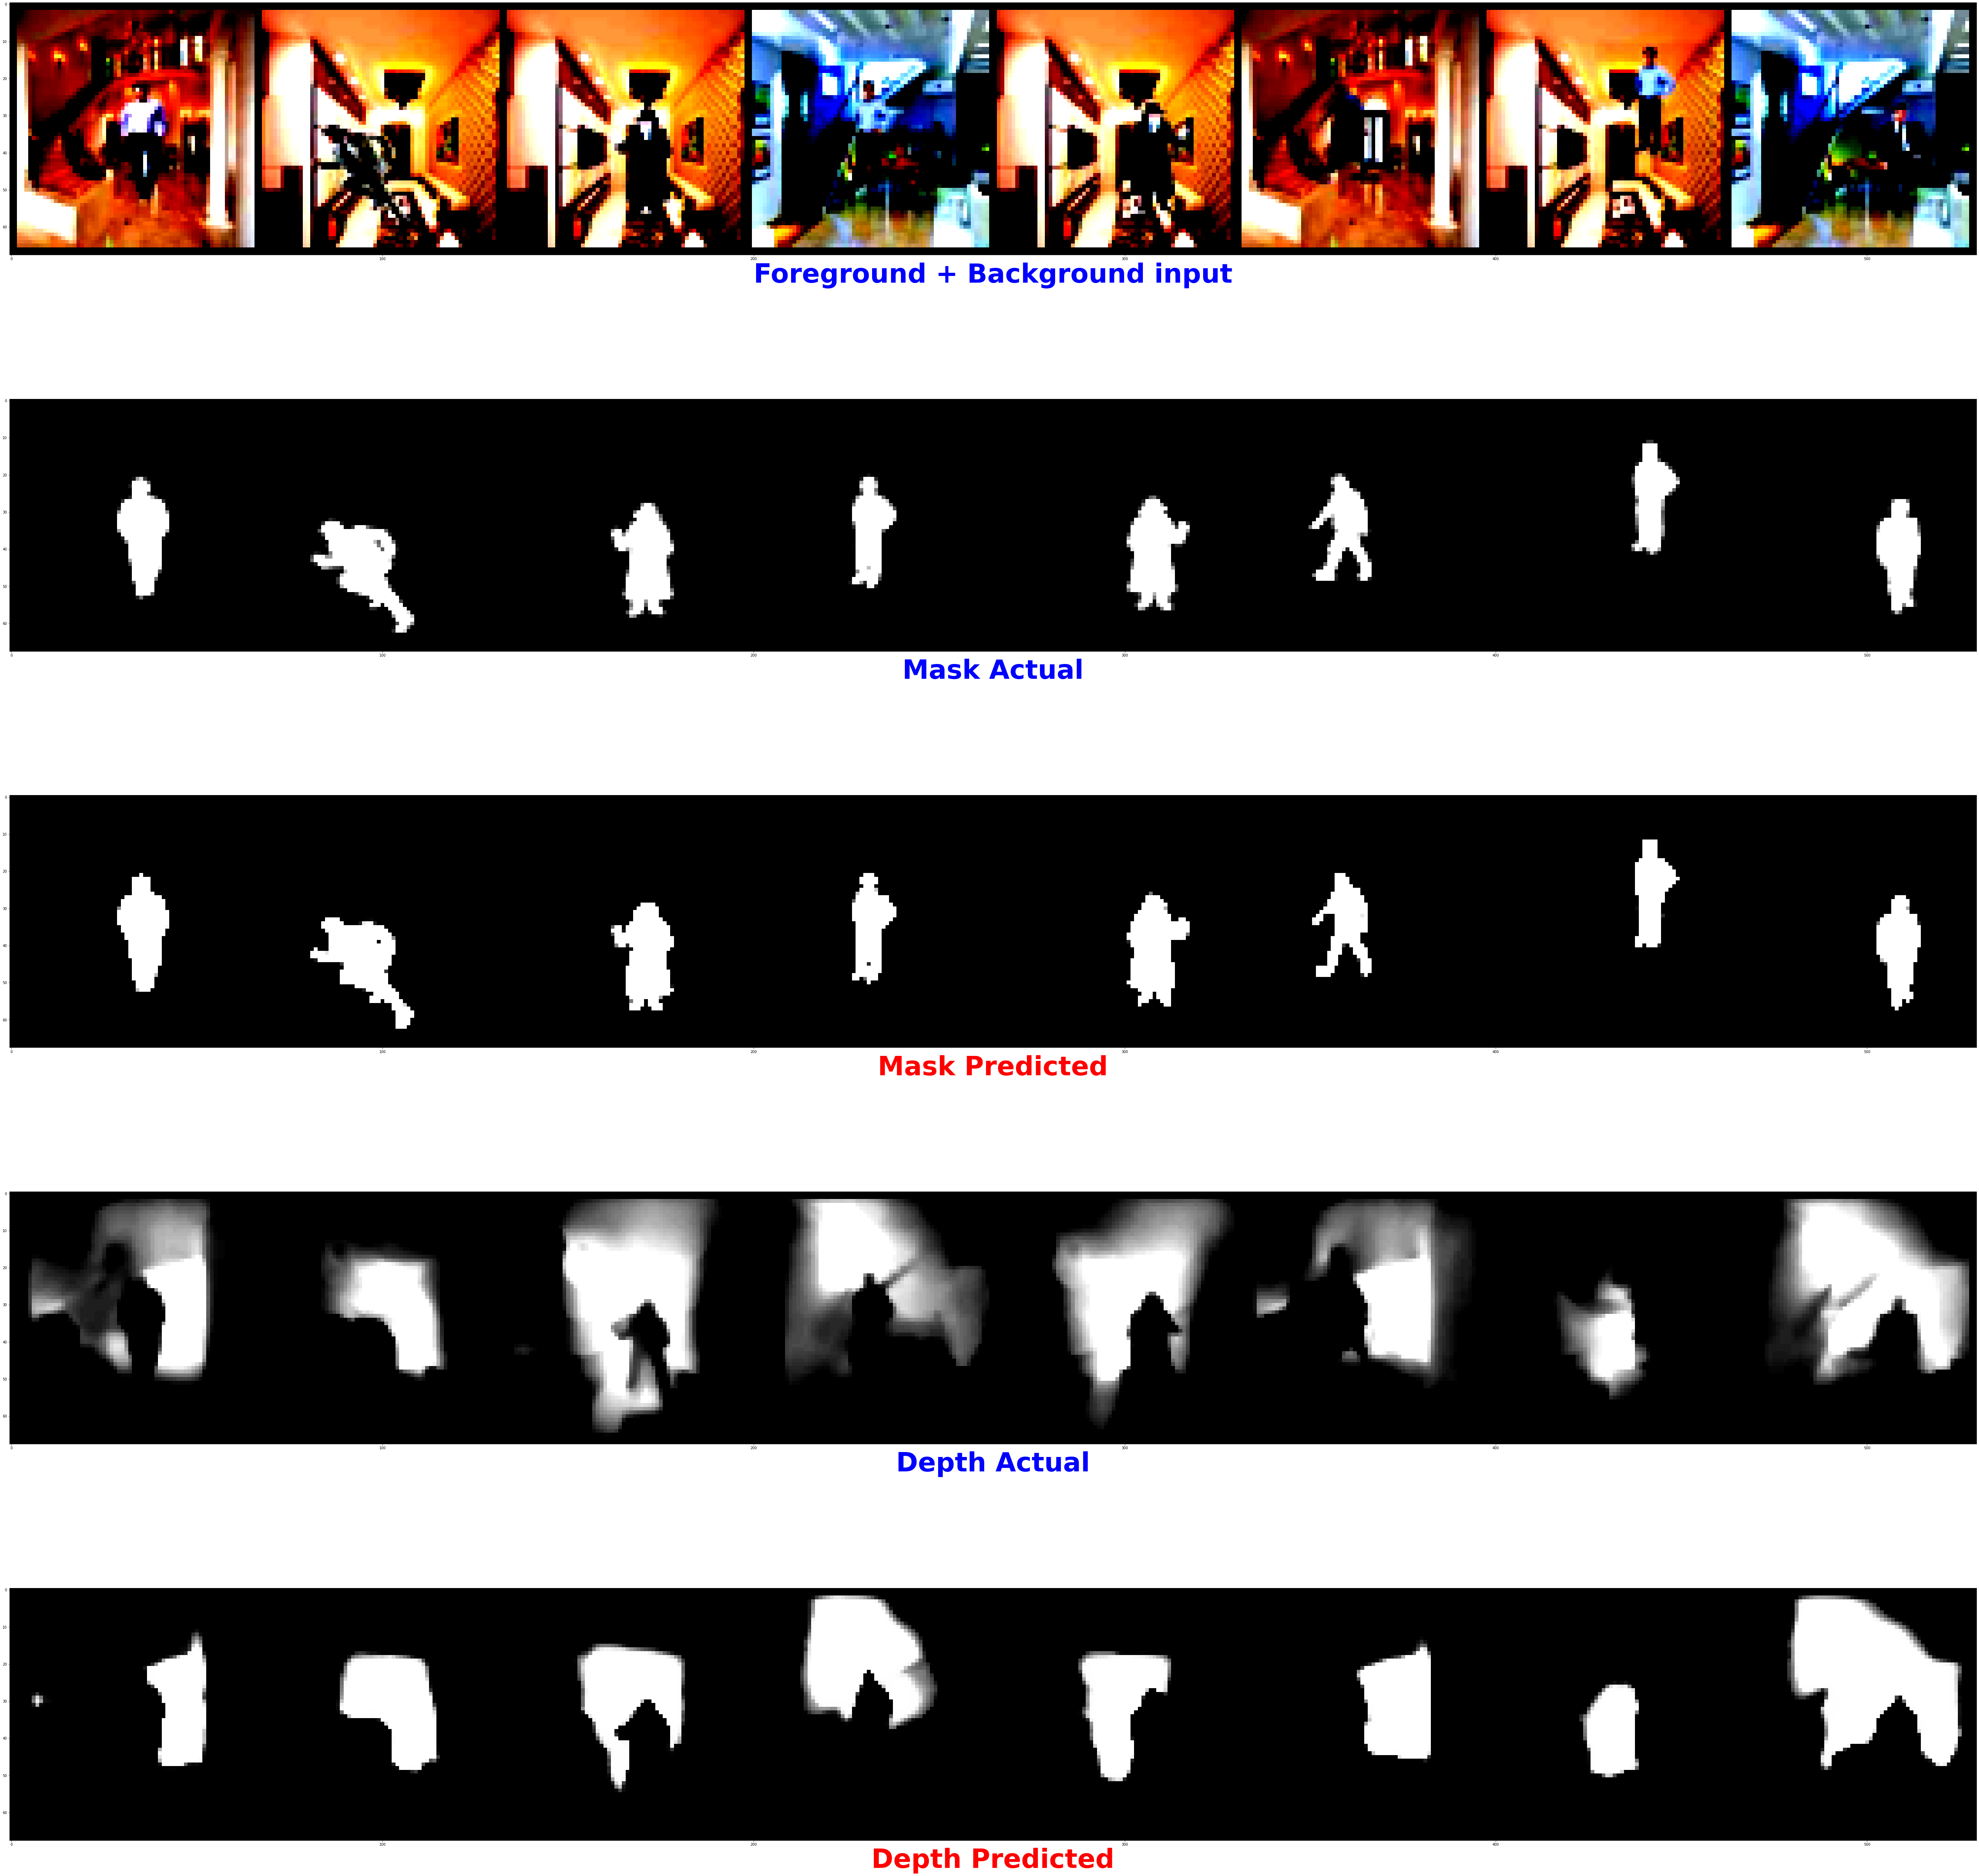

In [89]:
show1(test_image_epoch15["fg_bg"].resize_(8, 3, 64, 64), test_image_epoch15["mask_actual"].resize_(8, 1, 64, 64), test_image_epoch15["mask_pred"].resize_(8, 1, 64, 64), test_image_epoch15["depth_actual"].resize_(8, 1, 64, 64), test_image_epoch15["depth_pred"].resize_(8, 1, 64, 64))

**128 image size prediction**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


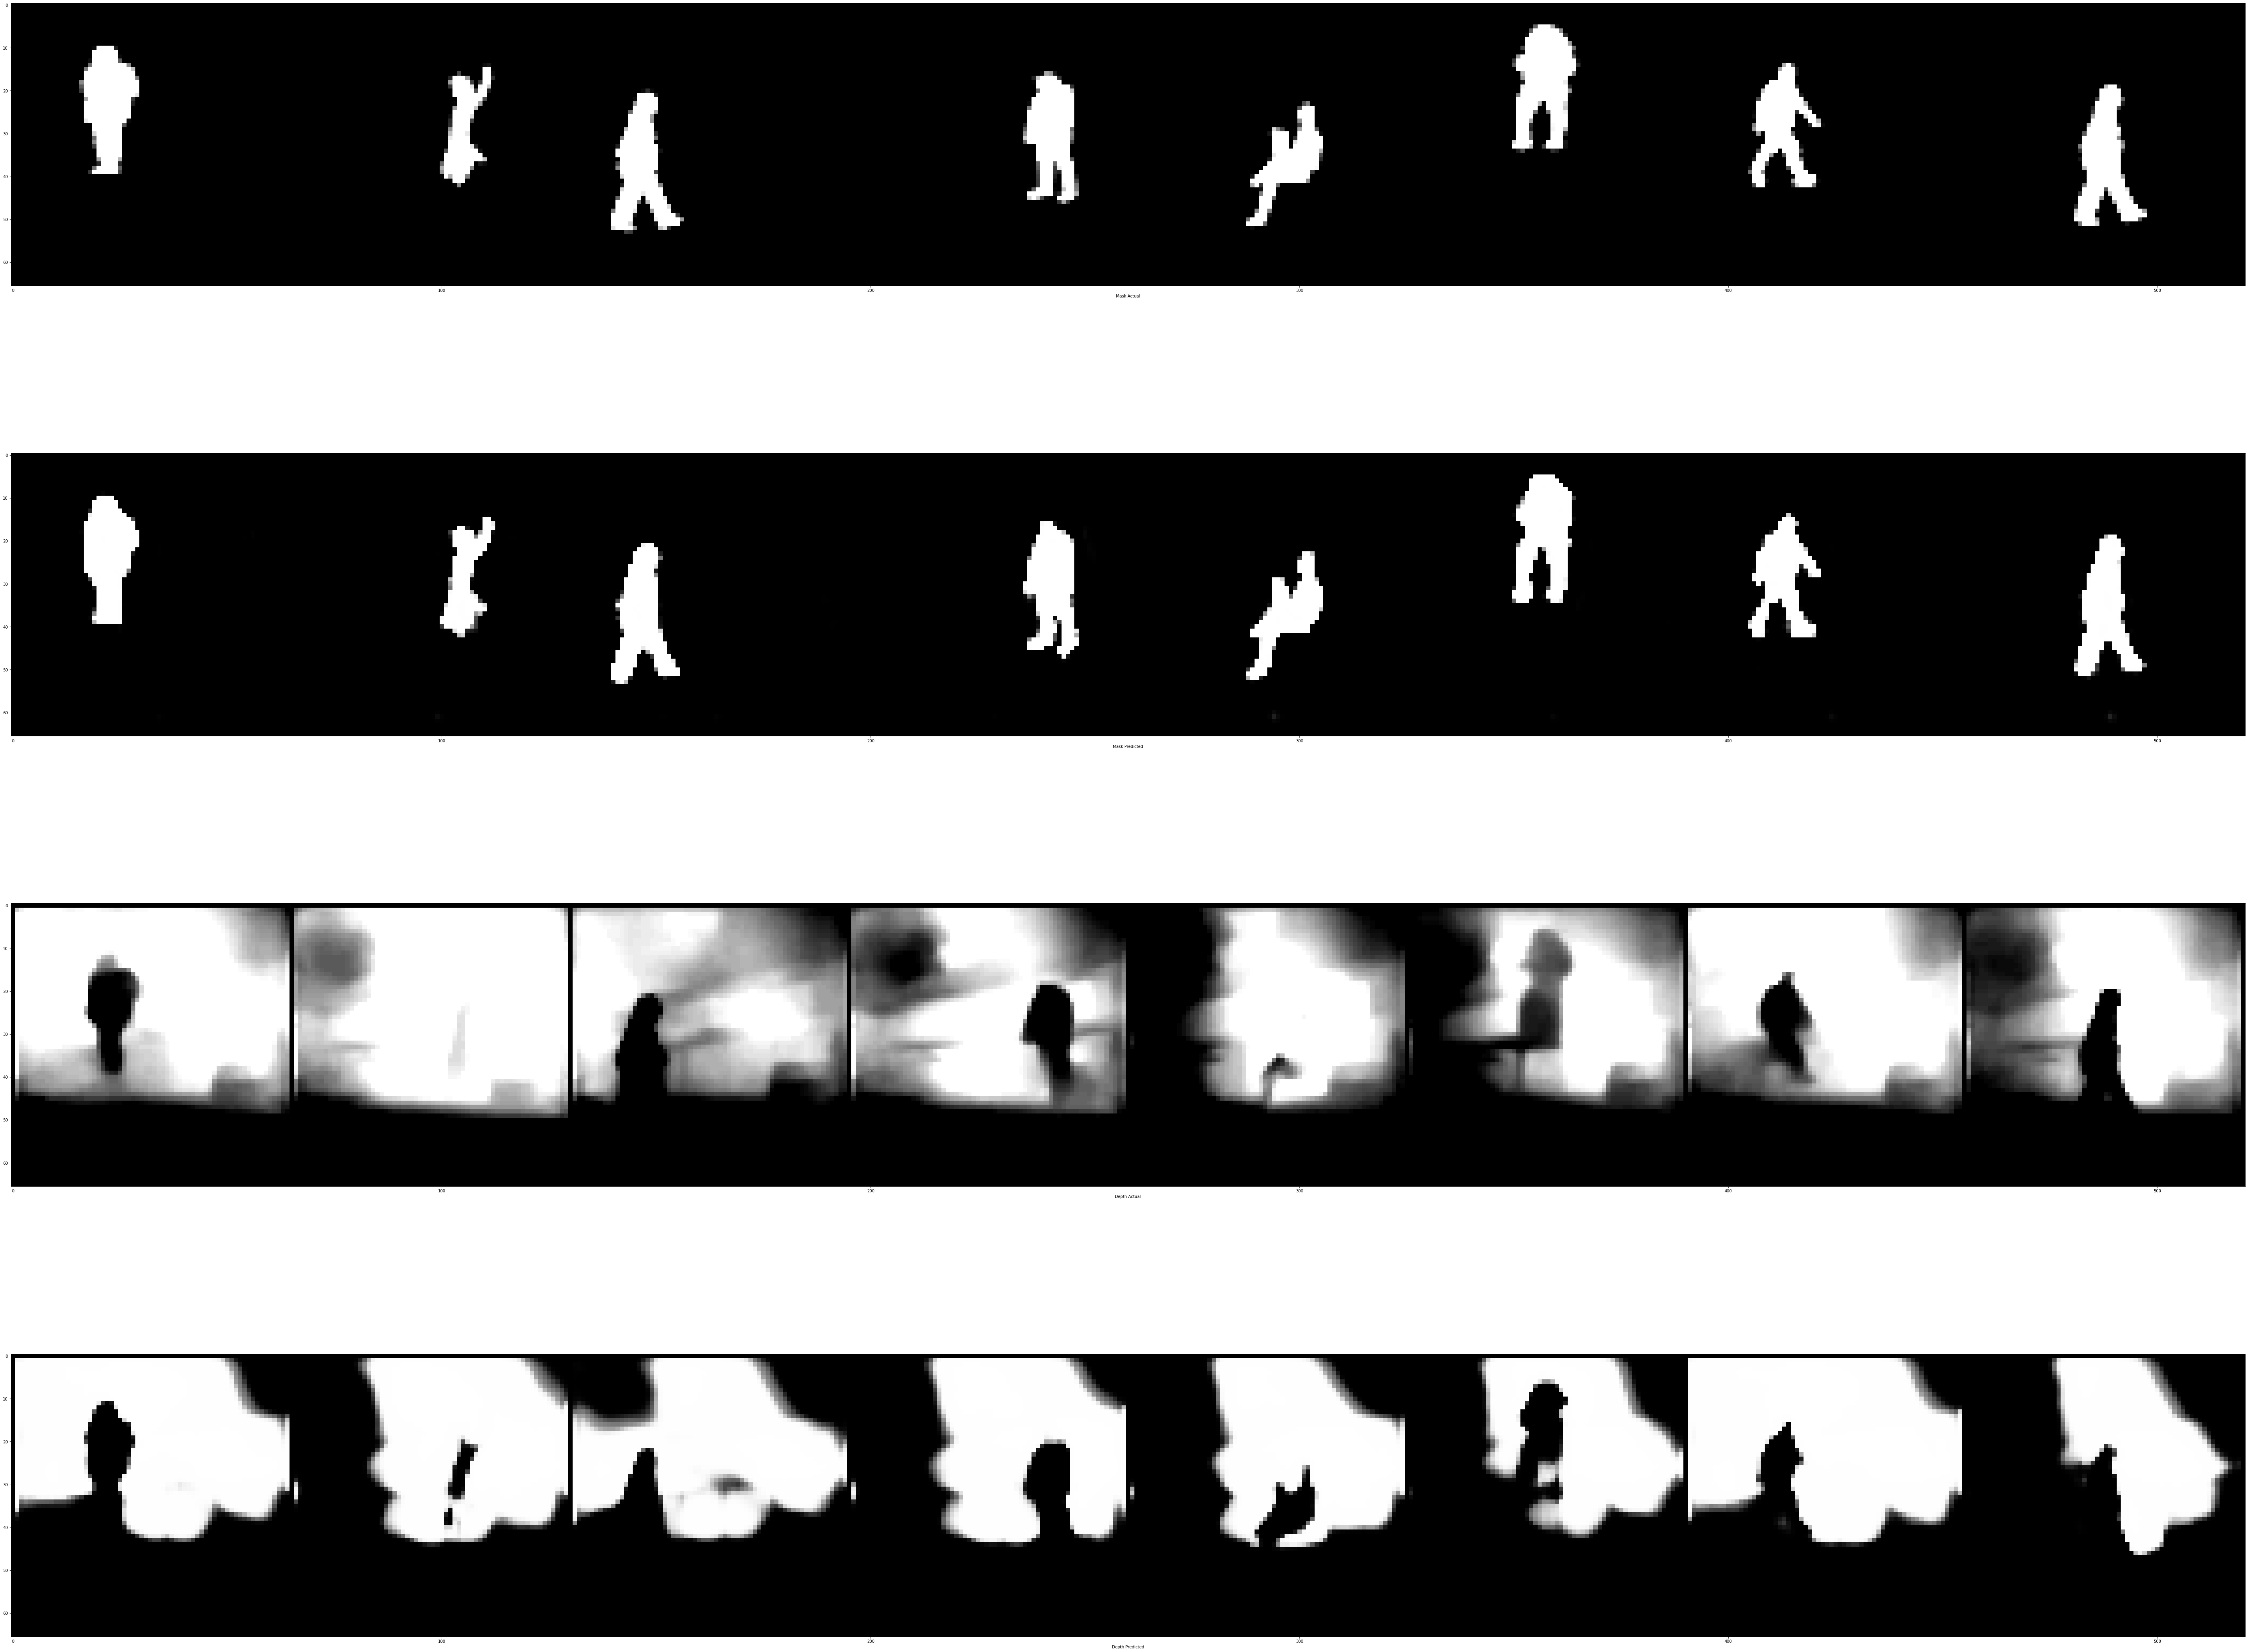

In [ ]:
# show(test_image['3_150']["mask_actual"], test_image['3_150']["mask_pred"], test_image['3_150']["depth_actual"], test_image['3_150']["depth_pred"])